In [1]:
from ftplib import FTP
import numpy as np
from sklearn import datasets
import netCDF4
import time
import matplotlib.pyplot as plt
from pydmd import DMD, CDMD, RDMD

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Download SST data

In [3]:
# # Import and save data locally
# ftp = FTP('ftp.cdc.noaa.gov')
# ftp.login()
# ftp.cwd('/Datasets/noaa.oisst.v2/')

# filenames = ['sst.wkmean.1990-present.nc', 'lsmask.nc']

# for filename in filenames:
#     localfile = open(filename, 'wb')
#     ftp.retrbinary('RETR ' + filename, localfile.write, 1024)
#     localfile.close()

# ftp.quit();

In [4]:
f = netCDF4.Dataset('sst.wkmean.1990-present.nc')

lat,lon = f.variables['lat'], f.variables['lon']
SST = f.variables['sst']
sst = SST[:]

f = netCDF4.Dataset('lsmask.nc')
mask = f.variables['mask']

Text(0.5, 1.0, 'First snapshot of SST')

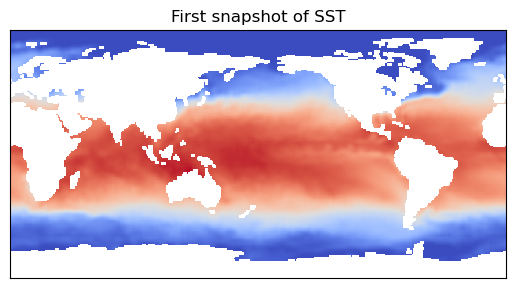

In [5]:
time_index = 0

masks = np.bool_(np.squeeze(mask))
snapshot = float("nan")*np.ones((180,360))
snapshot[masks] = sst[time_index,masks]

plt.imshow(snapshot, cmap=plt.cm.coolwarm)
plt.xticks([])
plt.yticks([])
plt.title('First snapshot of SST')

In [6]:
def compute_error(true, est):
    """
    Computes and returns relative error.
    """
    return np.linalg.norm(true - est) / np.linalg.norm(true)

## Sketching

In [7]:
from scipy.linalg import hadamard

def generate_countsketch_matrix(m, r, seed=None):
    rng = np.random.default_rng(seed)
    S = np.zeros((m, r))
    for i in range(r):
        row = rng.integers(0, m)
        S[row, i] = rng.choice([-1, 1])
    return S

def generate_shrt_matrix(m, r, seed=None):
    rng = np.random.default_rng(seed)
    p = 2**np.ceil(np.log2(m)).astype(int)
    H = hadamard(p)
    D = np.diag(rng.choice([-1, 1], size=p))
    HD = np.dot(H, D)
    if p < r :
        indices = rng.choice(p, size=r, replace=True)
    else:
        indices = rng.choice(p, size=r, replace=False)
    SHRT = HD[indices, :]
    return SHRT[:, :m].T  # Trim in case of padding

In [8]:
X = sst[:,masks]
X.shape

(1727, 44219)

In [9]:
snapshots_matrix = X.T

## Randomized DMD 
### (1) Varying oversampling number. 

In [10]:
num_trials = 10
m = snapshots_matrix.shape[1]
rank = 50 # target rank
oversampling = [0, 10, 25, 50, 200]

In [11]:
# Exact DMD
dmd_oversampling_error = np.zeros((len(oversampling), num_trials))
dmd_oversampling_times = np.zeros((len(oversampling), num_trials))

for i, p in enumerate(oversampling):
    for j in range(num_trials):  
        t0 = time.time()
        dmd = DMD(svd_rank=rank, exact=True)
        dmd.fit(X.T)
        t1 = time.time()

        dmd_oversampling_error[i, j] = (
            compute_error(snapshots_matrix, dmd.reconstructed_data)
        )
        dmd_oversampling_times[i, j] = (t1 - t0)

In [12]:
# RDMD with Gaussian sketch
oversampling_error = np.zeros((len(oversampling), num_trials))
oversampling_times = np.zeros((len(oversampling), num_trials))

for i, p in enumerate(oversampling):
    for j in range(num_trials):  

        test_matrix = np.random.randn(m, rank+p)
        t0 = time.time()
        rdmd = RDMD(svd_rank=rank, test_matrix=test_matrix).fit(
            snapshots_matrix
        )
        t1 = time.time()

        oversampling_error[i, j] = (
            compute_error(snapshots_matrix, rdmd.reconstructed_data)
        )
        oversampling_times[i, j] = (t1 - t0)

In [13]:
# RDMD with Count sketch
oversampling_error_count = np.zeros((len(oversampling), num_trials))
oversampling_times_count = np.zeros((len(oversampling), num_trials))

for i, p in enumerate(oversampling):
    for j in range(num_trials):
        test_matrix = generate_countsketch_matrix(m, rank+p)
        t0 = time.time()
        rdmd_count = RDMD(svd_rank=rank, test_matrix=test_matrix).fit(
            snapshots_matrix
        )
        t1 = time.time()

        oversampling_error_count[i, j] = (
            compute_error(snapshots_matrix, rdmd_count.reconstructed_data)
        )
        oversampling_times_count[i, j] += (t1 - t0) 

In [14]:
# RDMD with SHRT sketch
oversampling_error_shrt = np.zeros((len(oversampling), num_trials))
oversampling_times_shrt = np.zeros((len(oversampling), num_trials))

for i, p in enumerate(oversampling):
    for j in range(num_trials):
        test_matrix = generate_shrt_matrix(m, rank+p)
        t0 = time.time()
        rdmd_shrt = RDMD(svd_rank=rank, test_matrix=test_matrix).fit(
            snapshots_matrix
        )
        t1 = time.time()

        oversampling_error_shrt[i, j] = (
            compute_error(snapshots_matrix, rdmd_shrt.reconstructed_data)
        )
        oversampling_times_shrt[i, j] += (t1 - t0) 

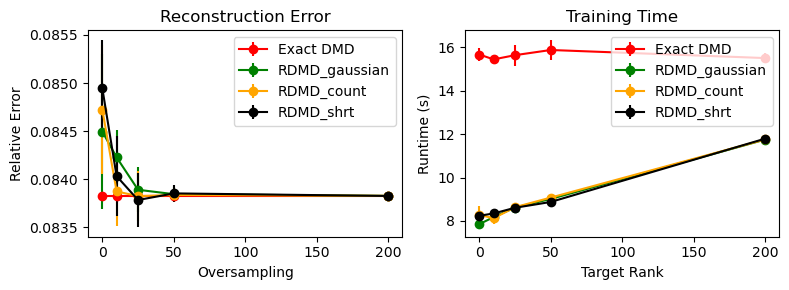

In [15]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.errorbar(oversampling, np.mean(dmd_oversampling_error, axis=1), yerr=np.std(dmd_oversampling_error, axis=1), fmt='-o', c="r", label="Exact DMD")
plt.errorbar(oversampling, np.mean(oversampling_error, axis=1), yerr=np.std(oversampling_error, axis=1), fmt='-o', c="g", label="RDMD_gaussian")
plt.errorbar(oversampling, np.mean(oversampling_error_count, axis=1), yerr=np.std(oversampling_error_count, axis=1), fmt='-o', c="orange", label="RDMD_count")
plt.errorbar(oversampling, np.mean(oversampling_error_shrt, axis=1), yerr=np.std(oversampling_error_shrt, axis=1), fmt='-o', c="k", label="RDMD_shrt")

plt.title("Reconstruction Error")
plt.xlabel("Oversampling")
plt.ylabel("Relative Error")
plt.legend()

plt.subplot(1, 2, 2)
plt.errorbar(oversampling, np.mean(dmd_oversampling_times, axis=1), yerr=np.std(dmd_oversampling_times, axis=1), fmt='-o', c="r", label="Exact DMD")
plt.errorbar(oversampling, np.mean(oversampling_times, axis=1), yerr=np.std(oversampling_times, axis=1), fmt='-o', c="g", label="RDMD_gaussian")
plt.errorbar(oversampling, np.mean(oversampling_times_count, axis=1), yerr=np.std(oversampling_times_count, axis=1), fmt='-o', c="orange", label="RDMD_count")
plt.errorbar(oversampling, np.mean(oversampling_times_shrt, axis=1), yerr=np.std(oversampling_times_shrt, axis=1), fmt='-o', c="k", label="RDMD_shrt")

plt.title("Training Time")
plt.xlabel("Target Rank")
plt.ylabel("Runtime (s)")
plt.legend()
plt.tight_layout()
plt.show()

### (2) Varying target rank

In [29]:
p = 25
target_rank = [5, 10, 25, 50, 100, 250] # of smapling rows

In [30]:
# Exact DMD
dmd_error = np.zeros((len(target_rank), num_trials))
dmd_times = np.zeros((len(target_rank), num_trials))

for i, rank in enumerate(target_rank):
    for j in range(num_trials):  
        t0 = time.time()
        dmd = DMD(svd_rank=rank, exact=True)
        dmd.fit(X.T)
        t1 = time.time()

        dmd_error[i, j] = (
            compute_error(snapshots_matrix, dmd.reconstructed_data)
        )
        dmd_times[i, j] = (t1 - t0)

In [31]:
# RDMD with Gaussian sketch
oversampling_error = np.zeros((len(target_rank), num_trials))
oversampling_times = np.zeros((len(target_rank), num_trials))

for i, rank in enumerate(target_rank):
    for j in range(num_trials):  
        test_matrix = np.random.randn(m, rank+p)
        t0 = time.time()
        rdmd = RDMD(svd_rank=rank, test_matrix=test_matrix).fit(
            snapshots_matrix
        )
        t1 = time.time()

        oversampling_error[i, j] = (
            compute_error(snapshots_matrix, rdmd.reconstructed_data)
        )
        oversampling_times[i, j] = (t1 - t0)

In [32]:
# RDMD with Count sketch
oversampling_error_count = np.zeros((len(target_rank), num_trials))
oversampling_times_count = np.zeros((len(target_rank), num_trials))

for i, rank in enumerate(target_rank):
    for j in range(num_trials):
        test_matrix = generate_countsketch_matrix(m, rank+p)
        t0 = time.time()
        rdmd_count = RDMD(svd_rank=rank, test_matrix=test_matrix).fit(
            snapshots_matrix
        )
        t1 = time.time()

        oversampling_error_count[i, j] = (
            compute_error(snapshots_matrix, rdmd_count.reconstructed_data)
        )
        oversampling_times_count[i, j] += (t1 - t0) 

In [33]:
# RDMD with SHRT sketch
oversampling_error_shrt = np.zeros((len(target_rank), num_trials))
oversampling_times_shrt = np.zeros((len(target_rank), num_trials))

for i, rank in enumerate(target_rank):
    for j in range(num_trials):
        test_matrix = generate_shrt_matrix(m, rank+p)
        t0 = time.time()
        rdmd_shrt = RDMD(svd_rank=rank, test_matrix=test_matrix).fit(
            snapshots_matrix
        )
        t1 = time.time()

        oversampling_error_shrt[i, j] = (
            compute_error(snapshots_matrix, rdmd_shrt.reconstructed_data)
        )
        oversampling_times_shrt[i, j] += (t1 - t0) 

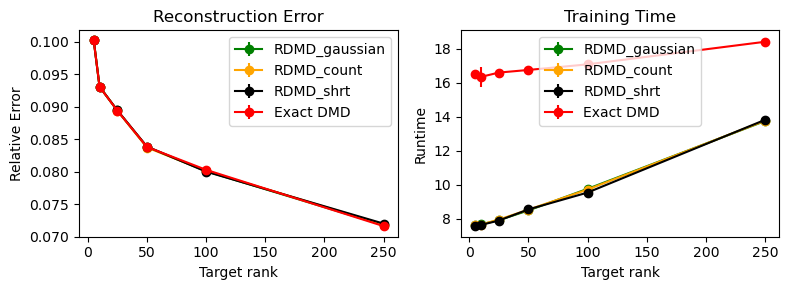

In [37]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)

plt.errorbar(target_rank, np.mean(oversampling_error, axis=1), yerr=np.std(oversampling_error, axis=1), fmt='-o', c="g", label="RDMD_gaussian")
plt.errorbar(target_rank, np.mean(oversampling_error_count, axis=1), yerr=np.std(oversampling_error_count, axis=1), fmt='-o', c="orange", label="RDMD_count")
plt.errorbar(target_rank, np.mean(oversampling_error_shrt, axis=1), yerr=np.std(oversampling_error_shrt, axis=1), fmt='-o', c="k", label="RDMD_shrt")
plt.errorbar(target_rank, np.mean(dmd_error, axis=1), yerr=np.std(dmd_error, axis=1), fmt='-o', c="r", label="Exact DMD")

plt.title("Reconstruction Error")
plt.xlabel("Target rank")
plt.ylabel("Relative Error")
# plt.xscale("log")
# plt.yscale("log")
plt.legend()

plt.subplot(1, 2, 2)

plt.errorbar(target_rank, np.mean(oversampling_times, axis=1), yerr=np.std(oversampling_times, axis=1), fmt='-o', c="g", label="RDMD_gaussian")
plt.errorbar(target_rank, np.mean(oversampling_times_count, axis=1), yerr=np.std(oversampling_times_count, axis=1), fmt='-o', c="orange", label="RDMD_count")
plt.errorbar(target_rank, np.mean(oversampling_times_shrt, axis=1), yerr=np.std(oversampling_times_shrt, axis=1), fmt='-o', c="k", label="RDMD_shrt")
plt.errorbar(target_rank, np.mean(dmd_times, axis=1), yerr=np.std(dmd_times, axis=1), fmt='-o', c="r", label="Exact DMD")


plt.title("Training Time")
plt.xlabel("Target rank")
plt.ylabel("Runtime")
# plt.xscale("log")
plt.legend()
plt.tight_layout()
plt.show()